<a href="https://colab.research.google.com/github/sachinkavindaa/ML-Project/blob/master/K_Fold_AUC_Adam_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Binary Classification with Sonar Dataset: Baseline
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from statistics import mean 

In [2]:
!git clone 'https://github.com/sachinkavindaa/Machine-learning-with-Python'

Cloning into 'Machine-learning-with-Python'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 137 (delta 44), reused 129 (delta 36), pack-reused 0
Receiving objects: 100% (137/137), 1.01 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [3]:
df = pd.read_csv('/content/Machine-learning-with-Python/ML/Diabetes/diabetes.csv')

In [4]:
df_mod = df[(df.Blood_Pressure != 0) & (df.BMI != 0) & (df.Glucose != 0)]
df_mod.shape

(724, 9)

In [5]:
def min_max_scaling(df_mod):
    
    df_norm = df_mod.copy()
    
    
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

df_scaled = min_max_scaling(df_mod)

In [6]:
feature_names = ['Pregnancies', 'Glucose', 'Blood_Pressure', 'Skin_Thickness', 'Insulin', 'BMI', 'Diabetes_Pedigree_Function', 'Age']
X = df_scaled[feature_names]
y = df_scaled.Outcome

In [7]:
def create_network():
    
    # Start neural network
    network = Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(Dense(units=10, activation='relu', input_shape=(8,)))

    # Add fully connected layer with a ReLU activation function
    network.add(Dense(units=3, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(Dense(units=1, activation='sigmoid'))

    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer='adam', # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
    
    # Return compiled network
    return network

In [8]:
def is_classifier(estimator):
   
    return getattr(estimator, "_estimator_type", None) == "classifier"

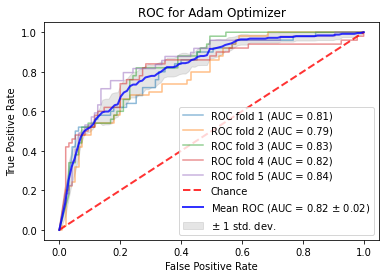

In [22]:
cv = StratifiedKFold(n_splits=5)
# Wrap Keras model so it can be used by scikit-learn
classifier = KerasClassifier(build_fn=create_network, 
                                 epochs=500, 
                                 batch_size=16, 
                                 verbose=0)

classifier._estimator_type = "classifier"
#Plotting the ROC curve
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
scores = []
cls_reports = []
colors = list(['tan','lime','orange','indigo','maroon'])
for i, (train, test) in enumerate(cv.split(X, y)):
    history = classifier.fit(X.iloc[train], y.iloc[train])
    score = classifier.score(X.iloc[test], y.iloc[test])
    y_pred = classifier.predict(X.iloc[test])
    cls_report = precision_recall_fscore_support(y.iloc[test],y_pred)
    viz = plot_roc_curve(classifier, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=0.5, lw=1.5, ax=ax )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    scores.append(score)
    cls_reports.append(cls_report)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC for Adam Optimizer")
ax.legend(loc="lower right")
plt.show()

In [23]:
mean(scores)

0.763821828365326

In [24]:
mean(aucs)

0.8198208378088077

No handles with labels found to put in legend.


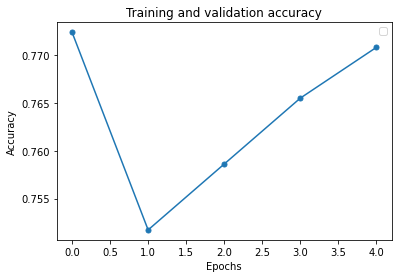

In [25]:
acc = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
plt.plot(range(5), scores, marker = '.', markersize = 10)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
mean(aucs)

0.8198208378088077

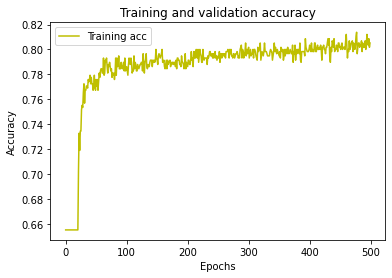

In [27]:
acc = history.history['accuracy']
#val_accuracy = history.history['val_accuracy']
plt.plot(range(500), acc, 'y', label='Training acc')
#plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
neg = []
pos = []
for i in cls_reports:
  neg.append([j[0] for j in i])
  pos.append([j[1] for j in i])

In [29]:
neg_recall = []
for i in range(len(neg)):
  neg_recall.append(neg[i][1])

In [30]:
mean(neg_recall)

0.8589473684210527

In [31]:
pos_recall = []
for i in range(len(pos)):
  pos_recall.append(pos[i][1])
mean(pos_recall)

0.5821224489795919